In [11]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [12]:
def cropResize(img, resize):
    h, w = img.shape[:2]
    min_dim = min(h, w)

    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2

    cropped_img = img[start_y:start_y + min_dim, start_x:start_x + min_dim]

    resize_img = cv.resize(cropped_img, (resize,resize))

    return resize_img

In [13]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cropResize(img, 256)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)
file_name = np.array(file_name)

## Data Augmentation

### Define Augmentation Function


In [14]:
def flip_horizontal(img):
    flipped = img[:, ::-1].copy()
    return flipped

def rotate_image(img, angle_degrees):
    angle = np.deg2rad(angle_degrees)
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    
    h, w = img.shape
    cx, cy = w // 2, h // 2
    
    rotated = np.zeros_like(img)

    for y in range(h):
        for x in range(w):
            x_rel, y_rel = x - cx, y - cy
            orig_x = int(cx + x_rel * cos_a + y_rel * sin_a)
            orig_y = int(cy - x_rel * sin_a + y_rel * cos_a)
            
            if 0 <= orig_x < w and 0 <= orig_y < h:
                rotated[y, x] = img[orig_y, orig_x]
    
    return rotated

def adjust_brightness(img, beta):
    bright = img.astype(np.int16) + beta
    bright = np.clip(bright, 0, 255)
    return bright.astype(np.uint8)

def augment_image(img):
    augmented_images = []
    augmented_images.append(flip_horizontal(img))     # Flip
    augmented_images.append(rotate_image(img, 15))    # Rotate 15 deg
    augmented_images.append(adjust_brightness(img, 10))  # Brightness +10
    return augmented_images

### Augmentation Process

In [15]:
data_augmented = []
labels_augmented = []
file_name_augmented = []

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    fname = file_name[i]

    data_augmented.append(img)
    labels_augmented.append(label)
    file_name_augmented.append(fname)

    augmented_imgs = augment_image(img)
    suffixes = ['_flip', '_rot', '_bright']
    
    for aug_img, suffix in zip(augmented_imgs, suffixes):
        data_augmented.append(aug_img)
        labels_augmented.append(label)
        file_name_augmented.append(fname + suffix)

In [16]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  60
Data setelah augmentasi:  240


## Data Preparation

### Define Preprocessing Function


In [45]:
def padding_baris(image):
    height, width = image.shape
    img_pad = np.zeros((height, width+1), dtype=image.dtype)
    for i in range(height):
        for j in range(width):
            img_pad[i][j] = image[i][j]
    return img_pad

def padding_kolom(image):
    height, width = image.shape
    img_pad = np.zeros((height+1, width), dtype=image.dtype)
    for i in range(height):
        for j in range(width):
            img_pad[i][j] = image[i][j]
    return img_pad

def convo_edge(image, kernel, jenis):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    if jenis != 'robert':
        padded_img = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    else:
        padded_baris = padding_baris(image)
        padded_img = padding_kolom(padded_baris)

    result = np.zeros((img_height, img_width), dtype=np.float32)

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)

    return result

def deteksi_tepi(image, kernelX, kernelY, jenis):
    hasilX = convo_edge(image, kernelX, jenis)
    hasilY = convo_edge(image, kernelY, jenis)
    M = np.sqrt((hasilX ** 2) + (hasilY ** 2))
    return M

def thresholding(citra, ambang):
    height, width = citra.shape
    hasil = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            if citra[i, j] >= ambang:
                hasil[i, j] = 255
            else:
                hasil[i, j] = 0
    return hasil

def dilasi(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    k_center_y = k_height // 2
    k_center_x = k_width // 2

    padded_img = np.pad(image, ((k_center_y, k_center_y), (k_center_x, k_center_x)), 
                        mode='constant', constant_values=0)

    hasil = np.zeros_like(image, dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            bagian = padded_img[i:i + k_height, j:j + k_width]
            if np.any((bagian == 255) & (kernel == 1)):
                hasil[i, j] = 255
    return hasil

def erosi(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    k_center_y = k_height // 2
    k_center_x = k_width // 2

    padded_img = np.pad(image, ((k_center_y, k_center_y), (k_center_x, k_center_x)), 
                        mode='constant', constant_values=0)

    hasil = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            cocok = True
            for k in range(k_height):
                for l in range(k_width):
                    if kernel[k, l] == 1 and padded_img[i + k, j + l] != 255:
                        cocok = False
                        break
                if not cocok:
                    break
            if cocok:
                hasil[i, j] = 255
    return hasil

def sharpening(img, kernel):
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(img, dtype=np.float32)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            region = padded[y:y+kh, x:x+kw]
            value = np.sum(region * kernel)
            output[y, x] = np.clip(value, 0, 255)

    return output.astype(np.uint8)

def gradientMorfologi(img, kernel):
    imgD = dilasi(img, kernel)
    imgE = erosi(imgD, kernel)
    hasil = imgD - imgE
    return hasil



# Kernel
kernelSharpening = np.array([[0, -0.25, 0],
                             [-0.25, 2, -0.25],
                             [0, -0.25, 0]])

robertX = np.array([[1, 0],
                    [0, -1]])

robertY = np.array([[0, 1],
                    [-1, 0]])

kernelMorfologi = np.array([[0, 1, 0],
                            [1, 1, 1],
                            [0, 1, 0]])



### Preprocessing

In [18]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data_augmented)): # Loop through each image and do preprocessing
	img = data_augmented[i]
	# img = cropResize(img,256)  
	img = sharpening(img, kernelSharpening)  
	dataPreprocessed.append(img)

### Feature Extraction

In [19]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [20]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [21]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [22]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [23]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [24]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [25]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [26]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [27]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [28]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [29]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [30]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [31]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [32]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [33]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [34]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [35]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [36]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,puyuh-9.jpg,puyuh,1726.672518,2096.260269,1608.916085,2011.024468,0.553887,0.537743,0.547722,0.537172,...,0.236709,0.232503,0.485557,0.481579,0.486528,0.482185,0.828674,0.792444,0.840358,0.800883
1,puyuh-9.jpg_flip,puyuh,1726.672518,2011.024468,1608.916085,2096.260269,0.553887,0.537172,0.547722,0.537743,...,0.236709,0.231919,0.485557,0.482185,0.486528,0.481579,0.828674,0.800883,0.840358,0.792444
2,puyuh-9.jpg_rot,puyuh,2293.832184,2672.952495,2207.170573,2548.972488,0.545148,0.533953,0.542595,0.533828,...,0.164582,0.162140,0.405323,0.401769,0.405687,0.402666,0.863450,0.839999,0.868609,0.847420
3,puyuh-9.jpg_bright,puyuh,1721.221017,2093.037632,1610.203370,2011.736532,0.569642,0.557107,0.563580,0.556690,...,0.282365,0.279080,0.530355,0.527634,0.531380,0.528280,0.812300,0.772279,0.824407,0.781125
4,puyuh-8.jpg,puyuh,1014.266115,1571.585236,1127.380668,1562.997001,0.491938,0.471658,0.491120,0.473559,...,0.156487,0.152817,0.395378,0.389955,0.395584,0.390918,0.897588,0.841642,0.886166,0.842507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,bebek-7.jpg_bright,bebek,86.294332,136.921538,76.926670,138.606920,0.750636,0.633779,0.704940,0.631503,...,0.018624,0.014822,0.139806,0.121938,0.136470,0.121745,0.960007,0.935901,0.964294,0.935112
236,bebek-6.jpg,bebek,67.421109,127.214348,79.331786,125.086521,0.675827,0.552762,0.622261,0.552954,...,0.016594,0.013514,0.132123,0.115515,0.128817,0.116249,0.972320,0.946954,0.967204,0.947841
237,bebek-6.jpg_flip,bebek,67.421109,125.086521,79.331786,127.214348,0.675827,0.552954,0.622261,0.552762,...,0.016594,0.013344,0.132123,0.116249,0.128817,0.115515,0.972320,0.947841,0.967204,0.946954
238,bebek-6.jpg_rot,bebek,317.895619,465.998616,340.766115,499.923291,0.638546,0.584174,0.616558,0.576506,...,0.020544,0.018566,0.144043,0.136054,0.143331,0.136257,0.952971,0.930165,0.949618,0.925081


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

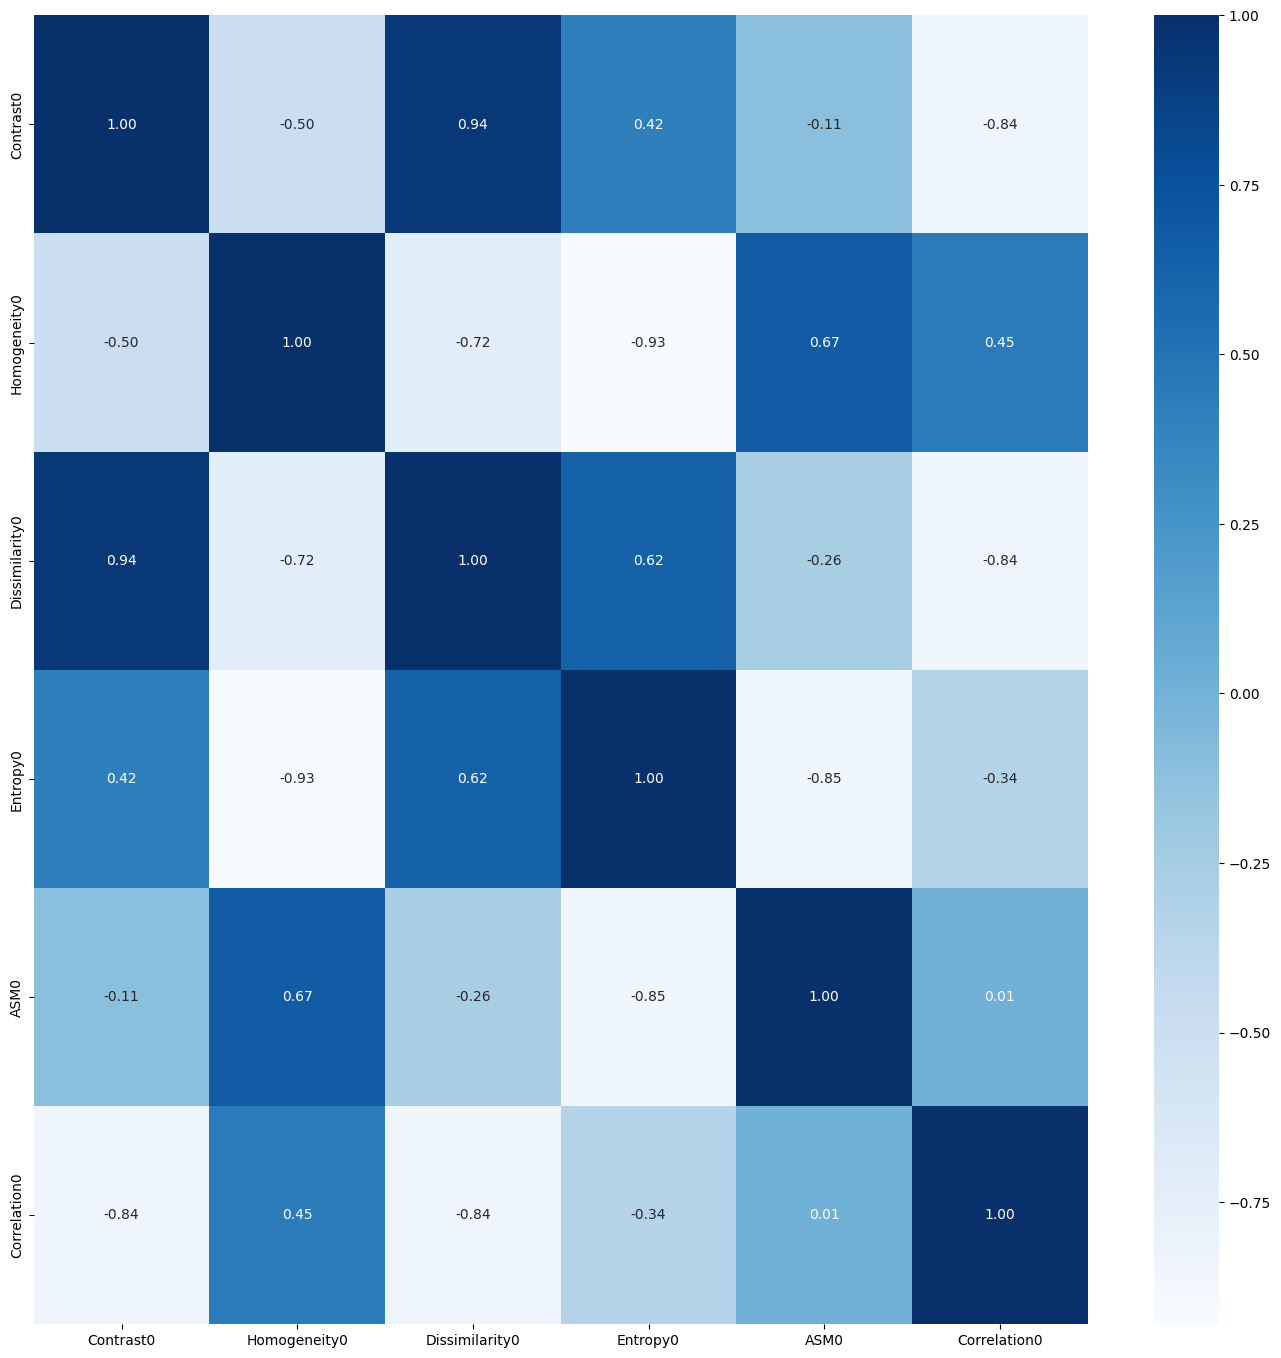

In [37]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [38]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(192, 6)
(48, 6)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [39]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [40]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [41]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

        ayam       1.00      1.00      1.00        65
       bebek       1.00      1.00      1.00        63
       puyuh       1.00      1.00      1.00        64

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192

[[65  0  0]
 [ 0 63  0]
 [ 0  0 64]]
Accuracy: 1.0

------Testing Set------
              precision    recall  f1-score   support

        ayam       1.00      1.00      1.00        15
       bebek       1.00      1.00      1.00        17
       puyuh       1.00      1.00      1.00        16

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

[[15  0  0]
 [ 0 17  0]
 [ 0  0 16]]
Accuracy: 1.0


### Train SVM Classifier

In [42]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        ayam       0.95      0.92      0.94        65
       bebek       0.97      1.00      0.98        63
       puyuh       0.95      0.95      0.95        64

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192

[[60  2  3]
 [ 0 63  0]
 [ 3  0 61]]
Accuracy: 0.9583333333333334

------Testing Set------
              precision    recall  f1-score   support

        ayam       1.00      0.80      0.89        15
       bebek       0.89      1.00      0.94        17
       puyuh       0.94      1.00      0.97        16

    accuracy                           0.94        48
   macro avg       0.95      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48

[[12  2  1]
 [ 0 17  0]
 [ 0  0 16]]
Accuracy: 0.9375


### Train KNN Classifier

In [43]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        ayam       1.00      0.94      0.97        65
       bebek       0.97      1.00      0.98        63
       puyuh       0.97      1.00      0.98        64

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192

[[61  2  2]
 [ 0 63  0]
 [ 0  0 64]]
Accuracy: 0.9791666666666666

------Testing Set------
              precision    recall  f1-score   support

        ayam       1.00      0.80      0.89        15
       bebek       0.89      1.00      0.94        17
       puyuh       0.94      1.00      0.97        16

    accuracy                           0.94        48
   macro avg       0.95      0.93      0.93        48
weighted avg       0.94      0.94      0.94        48

[[12  2  1]
 [ 0 17  0]
 [ 0  0 16]]
Accuracy: 0.9375


## Evaluation With Confusion Matrix

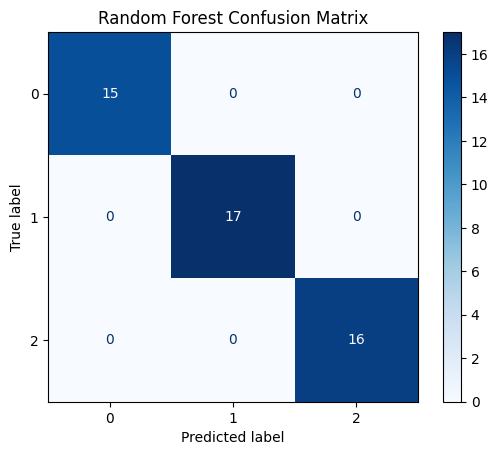

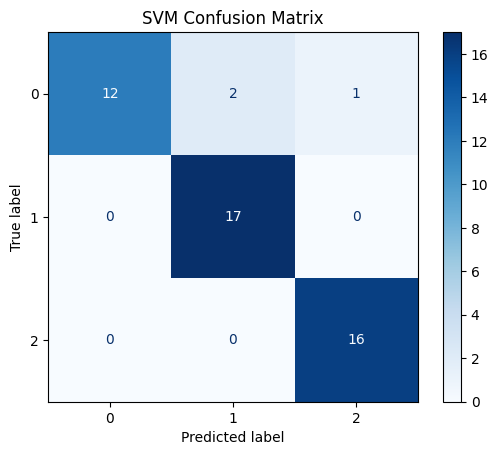

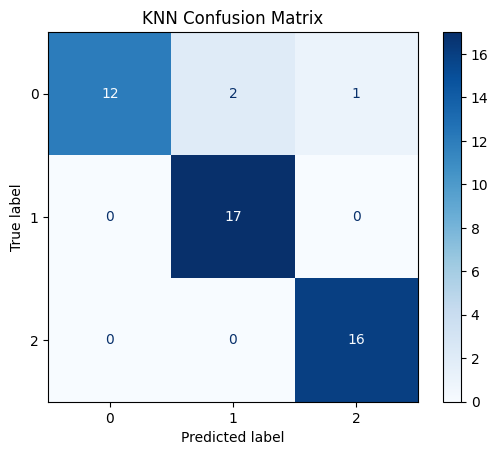

In [44]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")